# Case Study 5

<font size=4>Pankaj Kumar, Brady Arendale, Kay Ayala  
7/15/2020</font>

# Introduction

We will take a look at how missing values affect model results using a simple imputation strategy. We will simulate data missing completeley at random, data missing at random, and data missing not at random to see how different scenarios change the results.

# Data exploration

Let's take a look at the data first. We are using the Boston Housing dataset, available directly within Scikit-Learn.

In [73]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

data = load_boston()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.DataFrame(data.target, columns = ['MEDV'])

X.shape

(506, 13)

We have 506 observations and 13 explanatory variables. Let's look at the dataset description:

In [2]:
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

We are given information like the crime rate, nitric oxides concentration, and average number of rooms per dwelling. We are trying to predict the median value of homes in the area. Let's take a look at a few variables in detail.

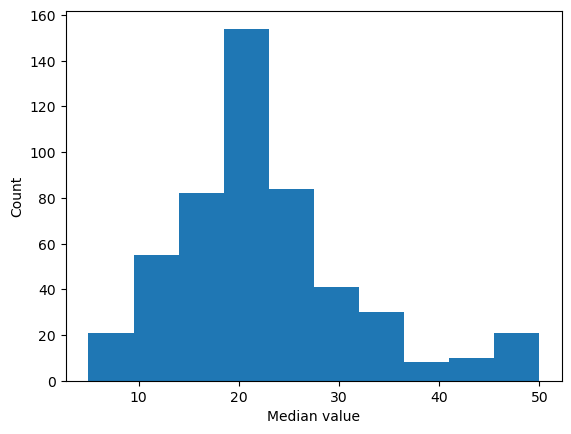

In [74]:
plt.hist(y['MEDV'])
plt.xlabel('Median value')
plt.ylabel('Count')
plt.show()

Median value is somewhat right-skewed with a median around $21,000.

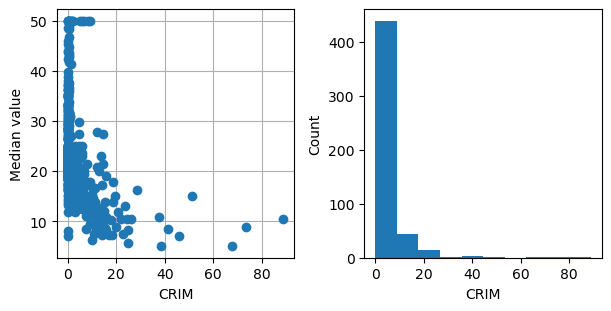

In [25]:
def plot_var(var):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
    
    ax0.scatter(X[var], y, zorder=2)
    ax0.set_xlabel(var)
    ax0.set_ylabel('Median value')
    ax0.grid(zorder=0)
    
    ax1.hist(X[var])
    ax1.set_xlabel(var)
    ax1.set_ylabel('Count')

plot_var('CRIM')

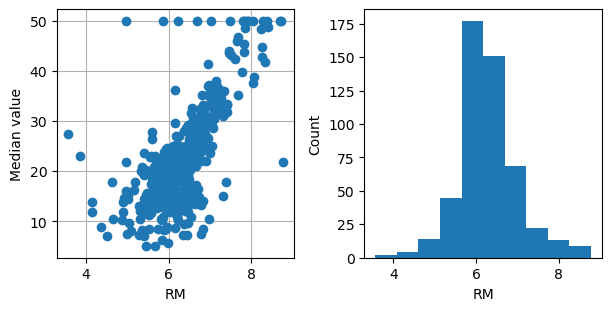

In [17]:
plot_var('RM')

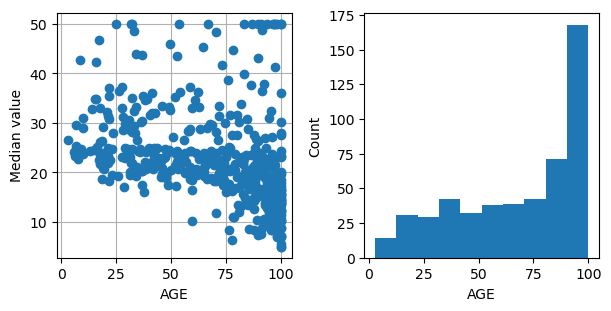

In [18]:
plot_var('AGE')

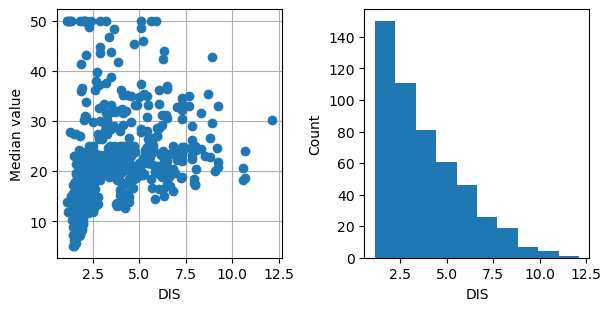

In [19]:
plot_var('DIS')

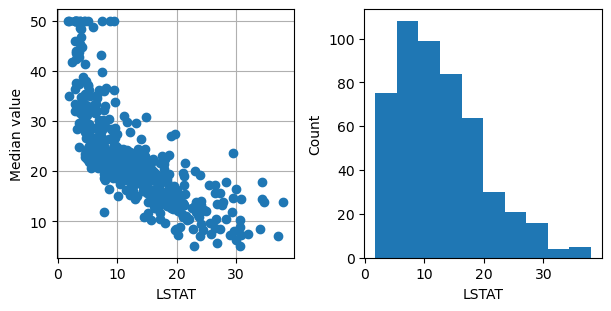

In [21]:
plot_var('LSTAT')

RM appears to be highly positively correlated with median value, and LSTAT appears to be highly negatively correlated. DIS and CRIM also appear to be fairly correlated with median value.

RM is fairly normally distributed, but the other variables are very skewed one way or the other.

In [80]:
X.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

Lastly, it is important to note that the data does not have any missing values as-is. Any missing values in this analysis will be ones we artificially create.

# Question 1: Baseline model

First, we will create a baseline model without removing any of the data to see how the model performs with all the data available. We will use a linear regression model due to its simplicity and the apparent linear relationships between predictors and median value.

In [70]:
model_baseline = LinearRegression()
model_baseline.fit(X, y)

LinearRegression()

In [72]:
from sklearn.metrics import mean_squared_error
y_pred = model_baseline.predict(X)
mean_squared_error(y, y_pred)

21.894831181729206

In [69]:
model_baseline.score(X, y)

0.7406426641094094

In [107]:
metrics = {'Name':['baseline'], 'MSE':[mean_squared_error(y, y_pred)], 'R^2':[model_baseline.score(X, y)]}

We will compare our models using mean squared error loss and R^2 as a goodness of fit estimate. Linear regression minimizes mean squared error (more precisely, sum of squared errors), and R^2 is essentially a scaled version of MSE that shows how closely the model fits the data. A lower MSE is better, and a higher R^2 is better (with a maximum value of 1).

MSE for the baseline model is 21.89, and R^2 is 0.74. We expect our imputations to produce higher MSEs and lower R^2 vaues.

# Question 2

We will first simulate data missing completely at random. To do this, we artificially introduce different amounts of missing values. We randomly select 1%, 5%, 10%, 20%, 33%, and 50% of data in a single column and change it to NA. We will use RM (average rooms) as our column since it has a high correlation with median value and should give us a good idea of the impact of missing values. We will impute the median of the remaining data in the RM column. We are using the median because it is robust to outliers and skew, which will make it useful for imputing any of our variables.

We will perform linear regressions for each threshold and use the imputed data to calculate MSE and R^2. We will look at all the values for these at the end.

In [105]:
def get_imputed_sample_random(frac, col):
    X_na = X.copy()
    X_na.loc[X_na.sample(frac=frac).index, col] = np.nan
    fill_value = X_na[col].mean()
    X_na = X_na.fillna(value=fill_value)
    return X_na

In [108]:
fractions = [.01, .05, .1, .2, .33, .5]
col = 'RM'

for frac in fractions:
    X_na = get_imputed_sample_random(frac, col)
    model = LinearRegression()
    model.fit(X_na, y)
    y_pred = model.predict(X_na)
    name = 'MCAR-'+str(frac)
    mse = mean_squared_error(y, y_pred)
    r2 = model.score(X_na, y)
    metrics['Name'].append(name)
    metrics['MSE'].append(mse)
    metrics['R^2'].append(r2)

# Question 3

Next, we will simulate data missing at random. To do this, we will randomly select values of RM and LSTAT to delete for thresholds of DIS greater than 4. We do this for fractions of 10%, 20%, and 30%. We chose LSTAT, because, as before, it has a high correlation with median price. Thus, we are removing a lot of valuable information that our model could use. We use median imputations as before. The median should be more representative of a typical value especially for LSTAT since it is fairly skewed.

In [132]:
def get_imputed_sample_random_conditional(frac, cols):
    X_na = X.copy()
    impute_idx = X_na[X_na['DIS']>4].sample(frac=frac).index
    X_na.loc[impute_idx, cols] = np.nan
    for col in cols:
        fill_value = X_na[col].median()
        X_na[col] = X_na[col].fillna(value=fill_value)
    return X_na

In [136]:
fractions = [.1, .2, .3]
cols = ['RM', 'LSTAT']

for frac in fractions:
    X_na = get_imputed_sample_random_conditional(frac, cols)
    model = LinearRegression()
    model.fit(X_na, y)
    y_pred = model.predict(X_na)
    name = 'MAR-'+str(frac)
    mse = mean_squared_error(y, y_pred)
    r2 = model.score(X_na, y)
    metrics['Name'].append(name)
    metrics['MSE'].append(mse)
    metrics['R^2'].append(r2)

# Question 4

For our last test, we will simulate data missing not at random. We will take the top 25% of values of CRIM (crime rate per capita) and delete the values of RM for these rows. We will then impute the median, as before.

In [148]:
threshold = X.CRIM.quantile(0.75)
X_na = X.copy()
X_na.loc[X_na['CRIM'] > threshold, 'RM'] = np.nan
X_na['RM'].isna().mean()

0.2509881422924901

In [153]:
fill_value = X_na['RM'].median()
X_na['RM'] = X_na['RM'].fillna(value=fill_value)

model = LinearRegression()
model.fit(X_na, y)

y_pred = model.predict(X_na)
name = 'MNAR-0.25'
mse = mean_squared_error(y, y_pred)
r2 = model.score(X_na, y)

metrics['Name'].append(name)
metrics['MSE'].append(mse)
metrics['R^2'].append(r2)

# Question 5

We previously imputed missing values using the median of the column, excluding the missing values. It was important to take the median after deleting the values so the deleted values would no longer have any effect on the analysis, including being used to impute themselves. This gives us the most realistic results for our imputation simulations.

Let's look at the models we fit for each simulation and analyze the results:

In [159]:
metrics_df = pd.DataFrame(metrics)
baseline_mse = metrics['MSE'][0]
baseline_r2 = metrics['R^2'][0]
metrics_df['% MSE increase'] = (metrics_df['MSE'] - baseline_mse)/baseline_mse
metrics_df['% R^2 decrease'] = (baseline_r2 - metrics_df['R^2'])/baseline_r2
metrics_df.round(3)

,Name,MSE,R^2,% MSE increase,% R^2 decrease
0,baseline,21.988,0.741,0.000,0.000
1,MCAR-0.01,22.478,0.734,0.022,0.009
2,MCAR-0.05,22.735,0.731,0.034,0.013
3,MCAR-0.1,22.096,0.738,0.005,0.003
4,MCAR-0.2,22.869,0.729,0.040,0.016
5,MCAR-0.33,24.141,0.714,0.098,0.036
6,MCAR-0.5,23.912,0.717,0.087,0.032
7,MAR-0.1,23.226,0.725,0.056,0.021
8,MAR-0.2,24.327,0.712,0.106,0.039
9,MAR-0.3,24.311,0.712,0.106,0.039


We find that for most simulations, the models after imputation perform slightly worse. The increase in MSE ranges from 0.5% to 10.6%, and the decrease in R^2 ranges from 0.3% to 3.9%. In general, the more data that has to be imputed, the worse the model performs. Simulations with data missing completely at random tend to fare better than situations with data missing at random on average. It may be the case that data missing completely at random is less likely to be crucial to the model's performance, but more likely this is because we deleted data for two columns instead of just one.

Interestingly, the simulation with data missing not at random performed better than the baseline. It could be that the data we chose to delete happened to hurt the model rather than help it, and imputing the median allowed the other, more important variables to control the predictions more. However, intentionally deleting values in the future is not likely to help our model performance. Instead, we should consider adding interaction terms or using other models.

# Conclusion

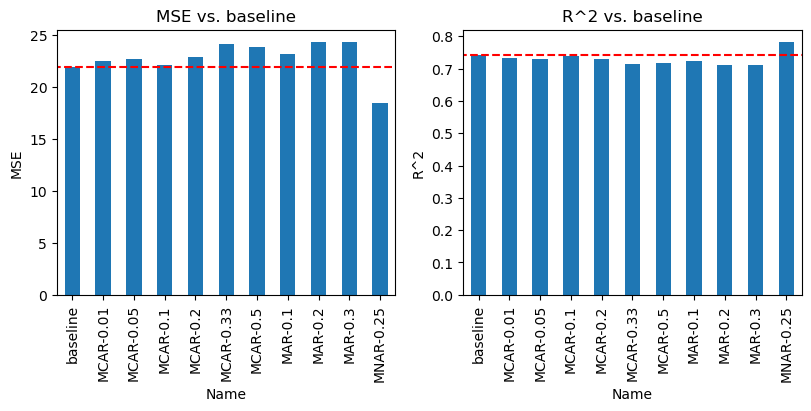

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

metrics_df.plot(kind='bar', x='Name', y='MSE', legend=False, ax=ax1)
ax1.hlines(baseline_mse, -1, 11, 'r', 'dashed')
ax1.set_title('MSE vs. baseline')
ax1.set_ylabel('MSE')

metrics_df.plot(kind='bar', x='Name', y='R^2', legend=False, ax=ax2)
ax2.hlines(baseline_r2, -1, 11, 'r', 'dashed')
ax2.set_title('R^2 vs. baseline')
ax2.set_ylabel('R^2')
plt.show()

The above graph summarizes our results. We artificially deleted values to simulate data missing completely at random, missing at random, and missing not at random using several different sampling percentages. We found that MAR tended to be worse than MCAR in the simulations we performed. We found that in some situations, imputing missing values can even give better results than if the true values were known, as with our MNAR simulation. However, this more likely suggests that the model is too simple rather than that imputation can improve performance. For the simulations we chose, MSE increases ranged from 0.5% to 10.6%. These results suggest that even with a simple imputation like imputing the median, model performance may still be able to be reasonably strong even with large amounts of missing values.